Application flow:
1. Find a track on YouTube (Get URL)
2. Input URL in app
3. Is it a solo or album track ?
4. If solo add track to validation loop, else propose album title, if ok validate and add all tracks to validation loop, else choose album title and add all tracks to validation loop
5. For each track in validation loop:
    - Parse title and description and propose metadata, if ok validate, else input manually
6. Once all is done, process all tracks : download, convert, add metadata.

In [1]:
from pytube import YouTube
from moviepy.editor import *
import mutagen
from mutagen.mp3 import MP3
from mutagen.easyid3 import EasyID3
from pydub import AudioSegment
from pydub.silence import *
import os
import sys
from utils.parsers import *
from utils.cmd_line import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
#AudioSegment.converter = r"C:\\Utility\\SoundVideoEditors\\ffmpeg-20190826-0821bc4-win64-static\\bin\\ffmpeg.exe"
#AudioSegment.ffprobe   = r"C:\\Utility\\SoundVideoEditors\\ffmpeg-20190826-0821bc4-win64-static\\bin\\ffprobe.exe"

In [2]:
def read_tracklist(text_file):
    with open(".\\inputs\\" + text_file, "r") as file:
        contents = file.read().split("\n")
    metadata = []
    for line in contents:
        s_line = line.split(";")
        metadata.append(s_line[0], ts_decompose(s_line[1]), s_line[2])
    return metadata

def amend_metadata(metadata):
    for k, v in metadata.items():
        print("")
        print(k, ":", v)
        while True:
            new = input("Enter new value or if no change required, press [Enter] ==> ")
            if new == "":
                break
            print("New value for {} is:".format(k))
            print("==>", new)
            check = input("Are you sure? [y]/[Enter]    [n] ==> ")
            if check == "" or check == "y":
                metadata[k] = new
                print("OK. {} value saved.".format(k))
                break
            else:
                continue
    print("Final metadata:")
    print_metadata(metadata)
    return metadata

In [10]:
print("++++++++++++++++++++++++++++ Vbtesh's video converter - VVC ++++++++++++++++++++++++++++ \n")

print("""Enter below the track's URL or the name of the file for multiple extracts. 
If you are using a file, it should be a *.txt with one URL per line.
File name format: in_*.txt
If the file is in the 'inputs' directory, enter its full name, else enter absolute path.""")
while True:
    payload = input("URL / File path: ")
    
    validation = []
    
    if payload[:8] == "https://":
        try:
            validation.append([YouTube(payload), payload])
            print("Got it, proceeding with one video...\n")
            break
        except:
            print("Invalid url or couldn't connect to server, check connection and try again. If this message persist, check input.\n")
            continue
    elif payload[:3] == "in_":
        with open(".\\inputs\\" + payload, "r") as file:
            contents = file.read().split("\n")
        for url in contents:
            try:
                validation.append([YouTube(url), url])
            except:
                print("Invalid file format or urls, check input file.\n")
                continue
        print("Trying to extract {number} videos? Yes [Enter] or [y], No [*] ".format(number = len(validation)))
        response = input("Response:")
        if response == "" or response == "y":
            print("Got it, proceeding...\n")
            break
        else:
            print("OK. Please check input file and reload.\n")
            continue
            
    else:
        print("Invalid input format, must be a YouTube url or a in_*.txt file.\n")
        continue

print("Constructing metadata for input tracks...\n")
download = []
for tune in validation:
    # Infos & album validation loop
    print("Handling {x}.".format(x=tune[0].title))
    print("URL: " + tune[1])
    while True:
        nature = input("Album or single track? album: [a]  single track: [t] ==> ")
        if nature == "a":
            album = True
            break
        elif nature == "t":
            album = False
            break
        else:
            continue
    
    if album:
        # if album, try parsing description for tracklist, if not found, look for file with data, if not found, ask to produce one
        print("Attempting to parse description for tracklist...\n")
        track_list = parse_tracklist(tune[0].description)
        if track_list:
            print("Track list found:")
            for track in track_list:
                print(track[0], "-", track[1], "-", track[2])
            check = input("\nValidate track list? [y]/[Enter]    [n] ==> ")
            if check == "n" or check == "no":
                track_list = None
            else:
                print("Track list validated.\n")
        if not track_list:
            print("Could not parse track list or invalid parsing result. Provide file name for track file.")
            print("Appropriate format is ts_*.txt, with the following format: 'track number' ; 'timestamp (HH:MM:SS)' ; 'title'")
            print("If the file is in the 'inputs' directory, enter its full name, else enter absolute path.")
            while True:
                file = input("File name: ")
                if file[-4:] == ".txt" and file[:3] == "ts_":
                    track_list = read_tracklist(file)
                    if track_list:
                        print("Track list found:")
                        for track in track_list:
                            print(track[0], "-", track[1], "-", track[2])
                        check = input("\nValidate track list? [y]/[Enter]    [n] ==> ")
                        if check != "" or check != "y":
                            print("Track list validated.\n")
                            break
                        else:
                            print("OK. Amend file and re submit.")
                    else:
                        print("No proper tracklist found. Check file and line format and re submit.")
                else:
                    print("Invalid file, check file name and re submit.")
        
        # Title
        print("Parsing title data...")
        metadata = parse_title(tune[0].title, True)
        print("Parsed metadata is as follows:")
        print_metadata(metadata)
        # Amendments
        change = input("Any amendments or additions? [y]    [n]/[Enter] ==> ")
        if change == "y":
            metadata = amend_metadata(metadata)
        # send to download list
        download.append([tune[0], tune[1], metadata, track_list])
    else:
        # if track:
        # parse title, make amendments
        metadata = parse_title(tune[0].title, False)
        print("Parsed metadata is as follows:")
        print_metadata(metadata)
        # Amendments
        change = input("Any amendments or additions? [y]    [n]/[Enter] ==> ")
        if change == "y":
            metadata = amend_metadata(metadata)
        # send to download list
        download.append([tune[0], tune[1], metadata])

final_info = []
for tube in download:
    if len(tube) == 3:
        title = tube[2]["title"]
        video_title = tube[0].title
        print("\nHandling one track:")
        print("Artist:", tube[2]["artist"])
        print("Title:", title)
        
        # Check if MP4 exists, if not download it
        tube_path = f".\\videos\\{video_title}.mp4"
        if not os.path.exists(tube_path):
            print("Downloading...")
            tube_path = tube[0].streams.first().download(output_path = ".\\videos\\")
            print("Download successful. Video file located at {}".format(tube_path))
        else:
            print("MP4 file already downloaded.")
        
        # Check if MP3 file exists, if not convert MP4
        audio_path = f".\\audios\\{title}.mp3"
        if not os.path.exists(audio_path):
            print("\nConverting to MP3...")
            with VideoFileClip(tube_path) as video:
                video.audio.write_audiofile(audio_path)
        else:
            print("MP3 file already exists.")
            
        print("Appending metadata to MP3 file...")
        audio_path = ".\\audios\\{filename}.mp3".format(filename = title)
        file = EasyID3(audio_path)
        metadata = tube[2]
        for k in metadata.keys():
            if k == "tags" or not metadata[k]:
                continue
            else:
                file[k] = metadata[k]
        file.save()
        print("Done.")
    else:
        album = tube[2]["album"]
        video_title = tube[0].title
        print(f"\nHandling one album with {len(tube[3])} tracks:")
        print("Artist:", tube[2]["artist"])
        print("Album:", album)
        
        # Check if MP4 exists, if not download it
        tube_path = f".\\videos\\{video_title}.mp4"
        if not os.path.exists(tube_path):
            print("Downloading...")
            tube_path = tube[0].streams.first().download(output_path = ".\\videos\\")
            print("Download successful. Video file located at {}".format(tube_path))
        else:
            print("MP4 file already downloaded.")
        
        # Check if MP3 file exists, if not convert MP4
        audio_path = f".\\audios\\{album}.mp3"
        if not os.path.exists(audio_path):
            print("\nConverting to MP3...")
            with VideoFileClip(tube_path) as video:
                video.audio.write_audiofile(audio_path)
        else:
            print("MP3 file already exists.")
            
        print("Initiating album split...")
        song = AudioSegment.from_file(audio_path, "mp3")
        # Loop through tracks and extract appropriate section of full album audio file then append it to tracks_audio
        tracks = tube[3]
        tracks_audio = []
        for idx, track  in zip(range(len(tracks)), tracks):
            begin_stamp = track[1]
            # If song is last, time stamp is begin stamp to end of full album audio file, else end stamp is begin stamp of next song
            if idx == len(tracks) - 1:
                track = song[begin_stamp:]
            else:
                end_stamp = tracks[idx+1][1]
                track = song[begin_stamp:end_stamp]
            tracks_audio.append(track)
            
        # Clean file extract and metadata increment
        metadata = tube[2]
        album = metadata['album']
        artist = metadata['artist']
        print(f"Creating album directory for {album}.")
        album_path = f".\\audios\\{artist} - {album}"
        
        try:
            os.mkdir(album_path)
            print("Done. Saving songs...")
        except FileExistsError:
            print("Directory already exists, saving inside existing directory...")
            
        for idx, audio in zip(range(len(tracks_audio)), tracks_audio):
            track_name = tracks[idx][2]
            file_name = f"{album} - Track {idx+1}"
            audio_path = f"{album_path}\\{file_name}.mp3"
            audio.export(audio_path, format="mp3")
            audio_mp3 = EasyID3(audio_path)
            for k in metadata.keys():
                if k == "tags" or not metadata[k]:
                    continue
                else:
                    audio_mp3[k] = metadata[k]
            audio_mp3["title"] = track_name
            audio_mp3["tracknumber"] = str(idx + 1)
            audio_mp3.save()
            print(f"Extracted track #{idx + 1} - {track_name}")
            
        print("All done. Deleting intial album MP3 file...")
        #os.remove(f".\\audios\\{album}.mp3")
        print(f"All done. Album can be found at {album_path}.")

print("All tube(s) have been extracted. Exiting...")

++++++++++++++++++++++++++++ Vbtesh's video converter - VVC ++++++++++++++++++++++++++++ 

Enter below the track's URL or the name of the file for multiple extracts. 
If you are using a file, it should be a *.txt with one URL per line.
File name format: in_*.txt
If the file is in the 'inputs' directory, enter its full name, else enter absolute path.


StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [11]:
audio_path = f".\\audios\\Illinois.mp3"
song = AudioSegment.from_file(audio_path, "mp3")

In [12]:
track_list = [
    [1, 1000, "death with dignity"],
    [2, 239000, "should have known better"],
    [3, 545000, "all of me wants all of you"],
    [4, 765000, "drawn to the blood"],
    [5, 962000, "eugene"],
    [6, 1106000, "fourth of july"],
    [7, 1385000, "the only thing"],
    [8, 1666000, "carrie & lowell"],
    [9, 1859000, "john my beloved"],
    [10, 2165000, "no shade in the shadow of the cross"],
    [11, 2323000, "blue bucket of gold"]]

track_list = [
    [1, 0, "Concerning the UFO Sighting Near Highland, Illinois"],
    [2, 129000, "The Black Hawk War, or, How to Demolish an Entire Civilization and Still Feel Good About Yourself in the Morning, or, We Apologize for the Inconvenience but You're Going to Have to Leave Now, or, 'I Have Fought the Big Knives and Will Continue to Fight Them Until They Are Off Our Lands!'"],
    [3, 263000, "Come On! Feel the Illinoise! (Part I  The World's Columbian Exposition   Part II  Carl Sandburg Visits Me in a Dream)"],
    [4, 668000, "John Wayne Gacy, Jr"],
    [5, 868000, "Jacksonville"],
    [6, 1192000, "A Short Reprise for Mary Todd, Who Went Insane, but for Very Good Reasons"],
    [7, 1240000, "Decatur, or, Round of Applause for Your Stepmother!"],
    [8, 1424000, "One Last 'Whoo Hoo!' for the Pullman"],
    [9, 1430000, "Chicago"],
    [10, 1795000, "Casimir Pulaski Day"],
    [11, 2148000, "To the Workers of the Rock River Valley Region, I Have an Idea Concerning Your Predicament"],
    [12, 2249000, "The Man of Metropolis Steals Our Hearts"],
    [13, 2625000, "Prairie Fire That Wanders About"],
    [14, 2757000, "A Conjunction of Drones Simulating the Way in Which Sufjan Stevens Has an Existential Crisis in the Great Godfrey Maze"],
    [15, 2776000, "The Predatory Wasp of the Palisades Is Out to Get Us!"],
    [16, 3099000, "They Are Night Zombies!! They Are Neighbors!! They Have Come Back from the Dead!! Ahhhh!"],
    [17, 3409000, "Let's Hear That String Part Again, Because I Don't Think They Heard It All the Way Out in Bushnell"],
    [18, 3449000, "In This Temple as in the Hearts of Man for Whom He Saved the Earth"],
    [19, 3484000, "The Seer's Tower"],
    [20, 3718000, "The Tallest Man, the Broadest Shoulders (Part I  The Great Frontier   Part II  Come to Me Only with Playthings Now)"],
    [21, 4141000, "Riffs and Variations on a Single Note for Jelly Roll, Earl Hines, Louis Armstrong, Baby Dodds, and the King of Swing, to Name a  Few"],
    [22, 4188000, "Out of Egypt, into the Great Laugh of Mankind, and I Shake the Dirt from My Sandals as I Run"]]

metadata = {
    "album": "Illinois",
    "artist": "Sufjan Stevens",
    "year": "2015"}

In [13]:
tracks_audio = []
for idx, track  in zip(range(len(track_list)), track_list):
    begin_stamp = track[1]
    # If song is last, time stamp is begin stamp to end of full album audio file, else end stamp is begin stamp of next song
    if idx == len(track_list) - 1:
        track = song[begin_stamp:]
    else:
        end_stamp = track_list[idx+1][1]
        track = song[begin_stamp:end_stamp]
    tracks_audio.append(track)

In [14]:
tracks_audio = []
for idx, track  in zip(range(len(track_list)), track_list):
    begin_stamp = track[1]
    begin_second = song[begin_stamp-500:begin_stamp+500]
    if idx != 0:
        begin_before = song[begin_stamp+9000:begin_stamp+10000]
    else:
        begin_before = song[:begin_stamp]
    print("\n", begin_before.rms)
    print(begin_second.rms)
    



0
0

2063
444

9126
705

2572
1197

1393
922

3979
727

5439
367

1613
3559

2843
4096

3721
347

2558
800

4651
979

2294
5816

2283
3043

4908
2665

1716
10517

2607
3783

3813
4920

3703
3145

331
516

3296
1353

688
2485


In [36]:
step = 700 #in milliseconds
silence_threshold = 400 #in rms
one_second = 1000/step #is always the number of steps required to last one real second
seconds = []
sounds = []
silences = []
last = 1
second = 1
for ml in range(1, len(song), step):
    sec_avg = song[last:ml].rms
    seconds.append(second)
    sounds.append(sec_avg)
    if sec_avg < silence_threshold:
        silences.append(second)
    second += 1
    last = ml

#for i, j in zip(seconds, sounds):
#    print(i, j)


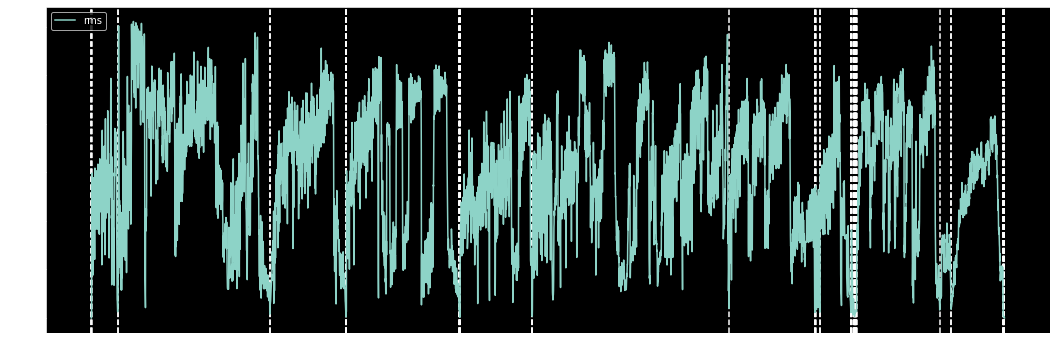

In [37]:
# Plots the variation in rms for each step in time (1, 2, 3, .. seconds) and draws a white line at each recognised silence
df = pd.DataFrame(data=sounds, index=seconds, columns=["rms"])
a4_dims = (18, 6)

fig, ax = plt.subplots(figsize=a4_dims)
for xc in silences:
    plt.axvline(x=xc, color='w', linestyle='--')
sns.lineplot(ax=ax, data=df)
plt.show()

In [35]:
print(silences)
# Takes the full list of silent seconds and return a list of the last silent second for each cluster of silences
ts = []
previous = 1
for s in silences:
    if previous + 1 == s:
        ts[-1] = s
        previous = s
    else:
        ts.append(s)
        previous = s

# This loop returns a list of timestamps in milliseconds, allowing pydub to read them directly
print(ts)
time_stamps = []
for stamp in ts:
    if stamp == 1:
        time_stamps.append(1)
    else:
        # Here the '-1' starts the song 1 second before to avoid abrupt impression of start up when listening
        time_stamps.append((stamp-(one_second)) * step)
time_stamps.pop()

print(len(time_stamps))
time_stamps

# Reconstructs a tracklist with track number, timestamps and title using the generated timestamps and the provided metadata
tracks = []
for track, ts in zip(track_list, time_stamps):
    tracks.append([track[0], ts, capitalize_each_word(track[2])])

tracks

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 1291, 1388, 1418, 1477, 1478, 1505, 1506, 1507, 2639, 2640, 2641, 8693, 8694, 8695, 8696, 8697, 8698, 8699, 8700, 8897, 8898, 8930, 8931, 8932, 12410, 12411, 12412, 12413, 12414, 12415, 12416, 12417, 12418, 12419, 12420, 12421, 12425, 12426, 12429, 12430, 12431, 12434, 12435, 12436, 12439, 12440, 17957, 17958, 17959, 17960, 17961, 17962, 17963, 17964, 17965, 17966, 17967, 17968, 17969, 17970, 17971, 17972, 17973, 17974, 17975, 17976, 17977, 17978, 17979, 17980, 17981, 17982, 17983, 17984, 17985, 18844, 20565, 21495, 21496, 21497, 21498, 21499, 21500, 21501, 21502, 21503, 21504, 21505, 21506, 21507, 21508, 21509, 21510, 21511, 35294, 35295, 37039, 37040, 37144, 37145, 37146, 37147, 37148, 37149, 37150, 37151, 37152, 37203, 37211, 37212, 37213, 37214, 37215, 37216, 37217, 37218, 37219, 37220, 37221, 37222, 37223, 37224, 37225, 37226, 37227, 37228, 37229, 37231, 37232, 37234, 37235, 37238, 37241, 37242, 37244, 37245, 37246, 37247, 37

[[1, 400.0, 'Concerning The UFO Sighting Near Highland, Illinois'],
 [2,
  700.0,
  "The Black Hawk War, Or, How To Demolish An Entire Civilization And Still Feel Good About Yourself In The Morning, Or, We Apologize For The Inconvenience But You're Going To Have To Leave Now, Or, 'I Have Fought The Big Knives And Will Continue To Fight Them Until They Are Off Our Lands!'"],
 [3,
  128100.0,
  "Come On! Feel The Illinoise! (Part I  The World's Columbian Exposition   Part II  Carl Sandburg Visits Me In A Dream)"],
 [4, 137800.0, 'John Wayne Gacy, Jr'],
 [5, 140800.0, 'Jacksonville'],
 [6,
  146800.0,
  'A Short Reprise For Mary Todd, Who Went Insane, But For Very Good Reasons'],
 [7, 149700.0, 'Decatur, Or, Round Of Applause For Your Stepmother!'],
 [8, 263100.0, "One Last 'Whoo Hoo!' For The Pullman"],
 [9, 869000.0, 'Chicago'],
 [10, 888800.0, 'Casimir Pulaski Day'],
 [11,
  892200.0,
  'To The Workers Of The Rock River Valley Region, I Have An Idea Concerning Your Predicament'],
 [12,

In [13]:
tracks_audio = album_split(song, tracks)
album_write(tracks_audio, metadata, tracks, "test_carrie_lowell")

Creating album directory for Carrie & Lowell.
Done. Saving songs...
Extracted track #1 - Death With Dignity
Extracted track #2 - Should Have Known Better
Extracted track #3 - All Of Me Wants All Of You
Extracted track #4 - Drawn To The Blood
Extracted track #5 - Eugene
Extracted track #6 - Fourth Of July
Extracted track #7 - The Only Thing
Extracted track #8 - Carrie & Lowell
Extracted track #9 - John My Beloved
Extracted track #10 - No Shade In The Shadow Of The Cross
Extracted track #11 - Blue Bucket Of Gold


In [25]:
# Album related functions
def album_split(album_audio, tracks):
    tracks_audio = []
    for idx, track  in zip(range(len(tracks)), tracks):
        begin_stamp = track[1]
        # If song is last, time stamp is begin stamp to end of full album audio file, else end stamp is begin stamp of next song
        if idx == len(tracks) - 1:
            track = album_audio[begin_stamp:]
        else:
            end_stamp = tracks[idx+1][1]
            track = album_audio[begin_stamp:end_stamp]
        tracks_audio.append(track)
    return tracks_audio


def album_write(tracks_audio, metadata, tracks, directory_name=None):

    album = metadata['album']
    artist = metadata['artist']

    print(f"Creating album directory for {album}.")
    if directory_name:
        album_path = f".\\audios\\{directory_name}"
    else:
        album_path = f".\\audios\\{artist} - {album}"

    try:
        os.mkdir(album_path)
        print("Done. Saving songs...")
    except FileExistsError:
        print("Directory already exists, saving inside existing directory...")
            
    for idx, audio in zip(range(len(tracks_audio)), tracks_audio):
        track_name = tracks[idx][2]
        file_name = f"{album} - Track {idx+1}"
        audio_path = f"{album_path}\\{file_name}.mp3"
        audio.export(audio_path, 
                     format="mp3",
                     tags={"album":album, 
                           "artist":artist, 
                           "title":track_name, 
                           "track":str(idx + 1), 
                           "date":metadata["year"]})
        print(f"Extracted track #{idx + 1} - {track_name}")
            


In [26]:
# General utility functions
# str_upper will return the string with the first letter of each word as upper case
# The rule is: each character preceded by a blank become uppercase.
def capitalize_each_word(string):
    uppered_string = ""
    for c in range(len(string)):
        if c == 0 and not string[c].isupper():
            uppered_string += string[c].upper()
        elif string[c-1] == " " and not string[c].isupper():
            uppered_string += string[c].upper()
        else:
            uppered_string += string[c]
    return uppered_string

In [65]:
a = np.array([23, 21, 32, 27, 23, 19, 32, 25, 23, 40, 23, 32])
b = np.array([40, 36, 28, 42, 50, 41, 49, 34, 39, 45, 41])

a_mean = a.mean()
b_mean = b.mean()


In [70]:
a_b = np.append(a, b)
a_b_mean = a_b.mean()
diff = b_mean - a_mean

print("Mean A: ", a_mean)
print("Mean B: ", b_mean)
print("Global mean: ", a_b_mean)
print("Mean difference: ", diff)
print("Contrast coding coefficient: ", diff/2)

print("\nMean A prediction: ", a_b_mean - diff/2)
print("Mean B prediction: ", a_b_mean + diff/2)

Mean A:26.666666666666668
Mean B:40.45454545454545
Global mean:33.26086956521739
Mean difference:13.787878787878785
Contrast coding coefficient:6.893939393939393

Mean A prediction:26.366930171278
Mean B prediction:40.15480895915678


In [78]:
from math import sqrt

hyp = sqrt(15**2 + 5**2)

velocity = (4, 6)


def view_dist_coef(velocity):
    max_dist = 50
    dist = sqrt(velocity[0]**2 + velocity[1]**2)
    return max_dist / dist

view_dist_coef((20,20))

1.7677669529663687